# Named-entity recognition

In [29]:
import spacy
from spacy.matcher import Matcher
from spacy.lang.en import English
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from tqdm import tqdm
import torch
random.seed(2022)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data path and filename given to read data
DATA_PATH = "../data/csvfiles/scraped_web"
filename = "beta_announcements.csv"

# Define the model to be used. For languages with transformer-based models, they are recommended as they
# tend to have higher performance for NER according to SpaCy's benchmarks
model = "en_core_web_trf"

os.listdir(DATA_PATH)

['beta_announcements.csv']

In [4]:
# Turn articles into dataframe. The volume of articles in a single website is low enough that dataframes
# provide a reasonable and convenient option for data manipulation.
df = pd.read_csv(DATA_PATH + "/" + filename)
df.head()

,Unnamed: 0,URL,text,title,published_date,summary
0,0,https://www.futureflight.aero/news-article/202...,The U.S. Army is to support flight testing of ...,U.S. Army Looks To Enlist Beta's Alia eVTOL wi...,2022-01-31 00:00:00,NaN
1,1,https://www.cae.com/news-events/press-releases...,• CAE and BETA to partner and create best in c...,CAE,NaN,NaN
2,2,https://evtol.com/features/why-evtol-developer...,When many people contemplate the benefits of a...,Why eVTOL developer Beta gives its employees f...,NaN,NaN
3,3,https://evtol.com/video/martine-rothblatt-flie...,"Martine Rothblatt, CEO of the biotechnology co...",Martine Rothblatt Flies Beta’s Alia,NaN,NaN
4,4,https://www.burlingtonfreepress.com/story/news...,Update: This story has been updated to reflect...,Ready for takeoff: Vermont nonprofit wants to ...,2021-06-08 00:00:00,NaN


In [6]:
# Load model
if model is not None:
    nlp = spacy.load(model)  # Load defined SpaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  # create blank Language class
    print("Created blank 'en' model")

# Get NER pipeline component for defined model
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
    print("Model does not contain NER pipeline component by default. One was created and added, but it must be trained.")
else:
    ner = nlp.get_pipe('ner')

Loaded model 'en_core_web_trf'


In [7]:

bodies = list(df['text'])
titles = list(df['title'])

In [8]:
def check_str(texts):
    strs = []
    count_ = 0
    for b in texts:
        if type(b) == str:
            strs.append(b)
        else:
            count_ += 1
    count_perc = count_/len(texts)
    return strs, count_, count_perc

bodies = check_str(bodies)[0]
titles = check_str(titles)[0]
# print([type(bodies[i]) for i in range(len(bodies))])

In [9]:
# Process texts as a stream, much faster than calling
# nlp() on each text
t_docs = list(nlp.pipe(titles))
b_docs = list(nlp.pipe(bodies))

c:\Users\TFLORA\capstone-project\win_venv\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [26]:
def group_ents(doc, print_ents = False):
    """Group entities by category and count labels and categories from `ents` attribute

    Args:
        doc (spacy.tokens.Doc.doc): Spacy document object for which to process entities
        print_ents (bool, optional): Print out each entity along with start and end characters, label, and label
        explanation. Defaults to False.

    Returns:
        dict: dictionary containing 3 dictionaries; 1 for the number of each label found in the document, 1 for 
        the number of mentions of each uniquely identified entity, and 1 with lists of entities belonging to each
        entity label
    """    
    if doc.ents:
        d = {"label_counts" : {}, "ent_counts" : {}, \
            "ents_per_label" : {}, "ent_data" : []}
        for ent in doc.ents:
            if print_ents:
                print("=================================================")
                print(f"Entity: {ent.text}\nStart char: {str(ent.start_char)}\nEnd char:{str(ent.end_char)}\
                    \nLabel: {ent.label_}\nLabel explanation: {spacy.explain(ent.label_)}")
                print("=================================================")
            d["label_counts"][ent.label_] = d["label_counts"].get(ent.label_, 0) + 1
            d["ent_counts"][ent.text] = d["ent_counts"].get(ent.text, 0) + 1
            if ent.label_ in d["ents_per_label"]:
                d["ents_per_label"][ent.label_].append(ent.text)
            else:
                d["ents_per_label"][ent.label_] = [ent.text]
            # d["ents_per_label"][ent.label_] = d["ents_per_label"].get(ent.label_, 0).append(ent.text)
        return d
    else:
        print("No entities in doc object")

print(t_docs[0])
group_ents(t_docs[0], print_ents = True)

U.S. Army Looks To Enlist Beta's Alia eVTOL with Flight Test Contract
U.S. Army - 0 - 9 - ORG - Companies, agencies, institutions, etc.
Beta - 26 - 30 - ORG - Companies, agencies, institutions, etc.
Alia - 33 - 37 - PRODUCT - Objects, vehicles, foods, etc. (not services)
eVTOL - 38 - 43 - PRODUCT - Objects, vehicles, foods, etc. (not services)


{'label_counts': {'ORG': 2, 'PRODUCT': 2},
 'ent_counts': {'U.S. Army': 1, 'Beta': 1, 'Alia': 1, 'eVTOL': 1},
 'ents_per_label': {'ORG': ['U.S. Army', 'Beta'],
  'PRODUCT': ['Alia', 'eVTOL']}}

In [24]:
type(t_docs[0])

spacy.tokens.doc.Doc

In [11]:
t_ent_lsts = [doc.ents for doc in t_docs]
b_ent_lsts = [doc.ents for doc in b_docs]

In [12]:
t_ent_lsts

[(U.S. Army, Beta, Alia, eVTOL),
 (CAE,),
 (),
 (Martine Rothblatt, Alia),
 (Vermont,),
 (Williston Observer,),
 (Amazon, Climate Fund, Fidelity),
 (BTV,),
 (BETA Technologies’, ALIA eVTOL, US, Air Force),
 (BETA, first, 20, Blade),
 (),
 (EVTOL,),
 (),
 (GAMA, Beta Technologies, Toyota Motor North America),
 (),
 (Beta, first),
 (),
 (),
 (Beta Technologies, Vermont),
 (),
 (),
 (),
 (Beta, Ava, the Edward Scissorhands),
 (),
 (),
 (Beta Technologies, eVTOL)]

In [13]:
grouped_ents = []
for b in b_docs:
    grouped_ents.append(group_ents(b))

In [14]:
# print(grouped_ents)
def count_dataset_ents(docs_ent_counts):
    """Obtains count data for an entire article dataset from a given company. 

    Args:
        docs_ent_counts (list): List of dictionaries containing count data for each document object in a corpus, as processed
        in `group_ents`

    Returns:
        dict: dictionary containing 3 other dictionaries; 1 one for the total number of mentions to unique entity identifiers,
        1 for the total count of each entity label type, and one with the entity lists obtained for each entity type
    """    
    c = {"entity_counts" : {}, "label_counts" : {}, "ent_lists" : {}}
    for doc_counts in docs_ent_counts:
        for l in doc_counts["label_counts"]:
            c["label_counts"][l] = c["label_counts"].get(l, 0) + 1
        for e in doc_counts["ent_counts"]:
            c["entity_counts"][e] = c["entity_counts"].get(e, 0) + 1
        epl = doc_counts["ents_per_label"]
        for ec in epl:
            if ec in c["ent_lists"]:
                c["ent_lists"][ec].extend(epl[ec])
            else:
                c["ent_lists"][ec] = epl[ec]
    return c

In [15]:
c = count_dataset_ents(grouped_ents)
c['label_counts']

{'ORG': 25,
 'PRODUCT': 23,
 'DATE': 24,
 'FAC': 12,
 'GPE': 23,
 'QUANTITY': 19,
 'PERSON': 25,
 'EVENT': 2,
 'LAW': 3,
 'CARDINAL': 23,
 'ORDINAL': 15,
 'TIME': 15,
 'WORK_OF_ART': 6,
 'NORP': 3,
 'MONEY': 8,
 'LOC': 9,
 'PERCENT': 6}

In [51]:
c['entity_counts']

{'The U.S. Army': 1,
 'Beta Technologies': 18,
 'Alia 250': 3,
 'today': 9,
 'Army': 1,
 'Beta': 17,
 'the U.S. Air Force': 3,
 'last year': 3,
 'Alia': 11,
 'Agility Prime': 4,
 'Burlington International Airport': 10,
 'Vermont': 16,
 'Plattsburg': 1,
 'New York': 8,
 '205 miles': 1,
 '8,000 feet': 3,
 'Kyle Clark': 22,
 'Will Roper': 1,
 'U.S.': 4,
 'the Air Force': 6,
 'the Reagan National Defense Forum': 1,
 'December 5, 2021': 1,
 "the Air Force's": 2,
 'Charles Brown': 1,
 'Afwerx': 1,
 'FAA': 8,
 'Part 23 type': 1,
 '2024': 8,
 'UPS': 8,
 '150': 3,
 'United Therapeutics': 13,
 'Blade Urban Air Mobility': 2,
 'CAE': 1,
 'BETA': 5,
 'BETA Technologies': 4,
 'UPS Flight Forward': 2,
 'United Therapeutics & Blade': 1,
 'ALIA eVTOL Aircraft': 1,
 'ALIA': 4,
 'eVTOL': 4,
 'tomorrow': 1,
 'Advanced Air Mobility': 1,
 'close to 75 years': 1,
 'Nick Leontidis': 1,
 'Civil Aviation Training Solutions': 1,
 'first': 14,
 'Blade': 4,
 'U.S. Air Force': 2,
 'hundreds of hours': 1,
 '200 mile

In [16]:
c["ent_lists"]["ORG"]

['The U.S. Army',
 'Beta Technologies',
 'Army',
 'Beta',
 'the U.S. Air Force',
 'Agility Prime',
 'Army',
 'Beta',
 'the Air Force',
 "the Air Force's",
 'FAA',
 'UPS',
 'United Therapeutics',
 'Blade Urban Air Mobility',
 'Beta',
 'CAE',
 'BETA',
 'BETA Technologies',
 'UPS Flight Forward',
 'United Therapeutics & Blade',
 'CAE',
 'BETA Technologies',
 'BETA',
 'CAE',
 'CAE',
 'BETA',
 'CAE',
 'Advanced Air Mobility',
 'BETA',
 'CAE',
 'BETA',
 'CAE',
 'CAE',
 'CAE',
 'Civil Aviation Training Solutions',
 'CAE',
 'BETA',
 'BETA',
 'BETA',
 'BETA',
 'the U.S. Air Force',
 'UPS Flight Forward',
 'United Therapeutics',
 'Blade',
 'U.S. Air Force',
 'BETA',
 'ALIA',
 'CAE',
 'CAE',
 'Beta Technologies',
 'Beta',
 'Beta',
 'Beta Technologies Photo',
 'Beta',
 'Beta',
 'Beta',
 'Beta',
 'Beta',
 'Beta',
 'Beta Technologies Photo',
 'Beta',
 'Beta',
 'Ferrier',
 'Ferrier',
 'eVTOL.com',
 'Lan',
 'Beta',
 'Alia',
 'Beta',
 'Beta Technologies',
 'Beta',
 'Beta',
 'Beta',
 'Beta',
 'Beta',
 '

In [17]:
# c['ent_lists']
from collections import Counter
all_orgs = c['ent_lists']["ORG"]
cat = "ORG"

def display_n(cat):
    print(f"Times {cat} are mentioned: {c['label_counts'][cat]}")

display_n(cat)
# print("Times organizations are mentioned:", len(all_orgs))


Times ORG are mentioned: 25


In [37]:
from collections import Counter
top_entities = lambda counts, n: Counter(counts['entity_counts']).most_common(n)

ent_cs = top_entities(c, 10)
ent_cs

[('Kyle Clark', 22),
 ('Beta Technologies', 18),
 ('Beta', 17),
 ('Vermont', 16),
 ('first', 14),
 ('Clark', 14),
 ('United Therapeutics', 13),
 ('Burlington', 13),
 ('two', 12),
 ('Alia', 11)]

In [33]:
def ent_bar_data(ent_counts: tuple):
    n = len(ent_counts)
    ent_texts = [ent_counts[i][0] for i in range(n)]
    ent_n = [ent_counts[i][1] for i in range(n)]
    return ent_texts, ent_n

## Visualizations
Below, we can find visualizations of entity counts for the dataset passed in the beginning of the notebook.

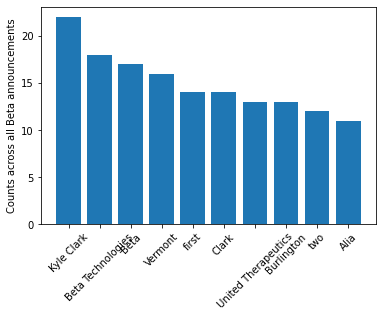

In [49]:
x, height = ent_bar_data(ent_cs)
plt.bar(x, height, width=.8)
plt.xticks(rotation = 45)
plt.ylabel("Counts across all Beta announcements")
plt.show()

In [20]:
grouped_ents

[{'label_counts': {'ORG': 15,
   'PRODUCT': 6,
   'DATE': 4,
   'FAC': 1,
   'GPE': 4,
   'QUANTITY': 2,
   'PERSON': 3,
   'EVENT': 1,
   'LAW': 1,
   'CARDINAL': 1},
  'ent_counts': {'The U.S. Army': 1,
   'Beta Technologies': 1,
   'Alia 250': 1,
   'today': 1,
   'Army': 2,
   'Beta': 3,
   'the U.S. Air Force': 1,
   'last year': 1,
   'Alia': 3,
   'Agility Prime': 2,
   'Burlington International Airport': 1,
   'Vermont': 1,
   'Plattsburg': 1,
   'New York': 1,
   '205 miles': 1,
   '8,000 feet': 1,
   'Kyle Clark': 1,
   'Will Roper': 1,
   'U.S.': 1,
   'the Air Force': 1,
   'the Reagan National Defense Forum': 1,
   'December 5, 2021': 1,
   "the Air Force's": 1,
   'Charles Brown': 1,
   'Afwerx': 1,
   'FAA': 1,
   'Part 23 type': 1,
   '2024': 1,
   'UPS': 1,
   '150': 1,
   'United Therapeutics': 1,
   'Blade Urban Air Mobility': 1},
  'ents_per_label': {'ORG': ['The U.S. Army',
    'Beta Technologies',
    'Army',
    'Beta',
    'the U.S. Air Force',
    'Agility Prim

In [21]:
from spacy import displacy
displacy.render(b_docs[0], style="ent")

In [22]:
c["ent_lists"]['EVENT']

['the Reagan National Defense Forum', 'Vermont Tech Jam']

In [23]:
c["entity_counts"]['ORG']

KeyError: 'ORG'

In [ ]:
titles = list(df['title'])

random.shuffle(titles)
ts = random.sample(titles, 10)
for t in ts:
    print(t)

In [ ]:
train_strs = {ts[0] : {"Beta" : "COMP", "Amazon's Climate Fund" : "PARTNER", "Fidelity" : "PARTNER"},
              ts[1] : {},
             ts[2] : {"Beta" : "COMP"},
             ts[3] : {"BETA Technologies":"COMP", "ALIA":"TECH"},
             ts[4] : {"Beta":"COMP", "Ava":"TECH"},
             ts[5] : {},
             ts[6] : {"Beta":"COMP", "Alia":"TECH"},
             ts[7] : {"Beta Technologies":"COMP"},
             ts[8] : {"Beta":"COMP"},
             ts[9] : {"Beta":"COMP", "Alia":"TECH"}}

In [ ]:
def patt_finder(substr, string):
    start_idx = string.index(substr)
    end_idx = start_idx + len(substr)
    return start_idx, end_idx

train_data = []
for i, sentence in enumerate(train_strs.keys()):
    assert(len(train_data)==i)
    num_ents = len(train_strs[sentence].keys())
    train_data.append([sentence, [None]*num_ents])
    for j in range(num_ents):
        sent_dict = train_strs[sentence]
        start_idx, end_idx = patt_finder(list(sent_dict.keys())[j], sentence)
        ent_str = list(sent_dict.values())[j]
        train_data[i][1][j] = (start_idx, end_idx, ent_str)

In [ ]:
train_data

In [ ]:
temp = [[lst[0], {"entities" : lst[1]}] for lst in train_data]
TRAINING_DATA = [tuple(dp) for dp in temp]
TRAINING_DATA

In [ ]:
# # Loop for 10 iterations
# for i in range(10):
#     # Shuffle the training data
#     random.shuffle(TRAINING_DATA)
#     # Create batches and iterate over them
#     for batch in spacy.util.minibatch(TRAINING_DATA, size=3):
#         # Split the batch in texts and annotations
#         texts = [text for text, annotation in batch]
#         annotations = [annotation for text, annotation in batch]
#         # Update the model
#         nlp.update(texts, annotations)
#         # Save the model
#         nlp.to_disk(path_to_model)